In [1]:
# IMPORTS : importing the libraries needed throughout the file 

import re
import time
import pickle
import numpy as np
import pandas as pd
import random
import nltk

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk import download
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [2]:
# MOUNT DRIVE : mounting the google drive to load the dataset into local runtime and save the models

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Twitter Sentiment Analysis

Mounted at /content/drive
/content/drive/MyDrive/Twitter Sentiment Analysis


In [3]:
# INITIALIZE VALUES : initializing variables needed throughout the final

data_file = 'data/training.1600000.processed.noemoticon.csv'
encoding_used = "ISO-8859-1"
data_columns  = ["target", "ids", "date", "flag", "user", "text"]
tweets_df = pd.read_csv(data_file, encoding = encoding_used, names = data_columns )

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

mystopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by',
              'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

english_stop_words =  stopwords.words('english')
stopwordlist = stopwords.words('english') + mystopwordlist

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos'] 

In [4]:
# PRINT : printing the top 20 rows of the dataset

tweets_df.head(20)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

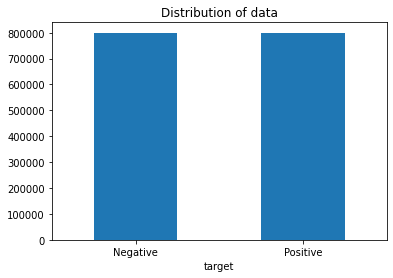

In [5]:
# PLOTTING CLASS COUNTS : plotting the count of different samples from each class

target_group = tweets_df.groupby('target').count()['text']
ax = target_group.plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation = 0)

In [6]:
# REPLACE : replace the value of the positive sentiment from 4 to 1 to perform the classification task

data = tweets_df[['target', 'text']]
data.columns = ["sentiment", "text"]
data['sentiment'] = data['sentiment'].replace(4,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
# PRINT : print 5 random tweets along with their sentiment

text, sentiment = list(data['text']), list(data['sentiment'])
samples = random.sample(range(1, len(text)), 5)
for i in samples:
  print(str(sentiment[i])+ " " + str(text[i]))

0 @jessi_lyn me fatty  haha and to be healthy! Good foods what not, no endless snacking like I'm use to haha
1 Awake and waiting for my cousin Maria to come ovaaa 
1 @TomMcFly I'm McSpaming a lot haha but common Tom!!! Remember your mexicans fans! we love you! 
1 @cjkuotwit I was wondering about that 
1 @ddlovato I can not wait for your ablum Demi and tour and EVERYTHING! I love you 


In [8]:
# FUNCTION TO PREPROCESS THE TWEETS : the function converts the tweets
#                               into lowercase ,removes any url, username, emojis; 
#                               lemmatizes the word to its root word 
#                               and converts exagerrated word into the 
#                               correct dictionary defined word.

def preprocess(textdata):
    processedText = []
    
    wordLemma = WordNetLemmatizer() 

    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" 
    userPattern       = '@[^\s]+' 
    alphaPattern      = "[^a-zA-Z0-9]" 
    sequencePattern   = r"(.)\1\1+"  
    seqReplacePattern = r"\1\1" 
    
    for tweet in textdata:
        tweet = tweet.lower() 
        tweet = re.sub(urlPattern,' URL',tweet) 
        for emoji in emojis.keys(): 
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])  
        tweet = re.sub(userPattern,' USER', tweet)  
        tweet = re.sub(alphaPattern, " ", tweet) 
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) 
        tweetwords = ''
        for word in tweet.split():
            if len(word) > 2 and word.isalpha():
                word = wordLemma.lemmatize(word)
                tweetwords += (word + ' ')
        processedText.append(tweetwords)
    return processedText

preprocessedtext = preprocess(text) 

In [9]:
# PRINTING : print the raw text and the preprocessed text to compare the both

for i in range(10):
  print("RAW : " + text[i])
  print("PREPROCESSED : " + preprocessedtext[i])

RAW : @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
PREPROCESSED : USER URL aww that bummer you shoulda got david carr third day EMOJIwink 
RAW : is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
PREPROCESSED : upset that can update his facebook texting and might cry result school today also blah 
RAW : @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
PREPROCESSED : USER dived many time for the ball managed save the rest out bound 
RAW : my whole body feels itchy and like its on fire 
PREPROCESSED : whole body feel itchy and like it fire 
RAW : @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
PREPROCESSED : USER not behaving all mad why here because can see you all over there 
RAW : @Kwesidei not the whole crew 
PREPROCESSED : USER not the whole crew 
RA

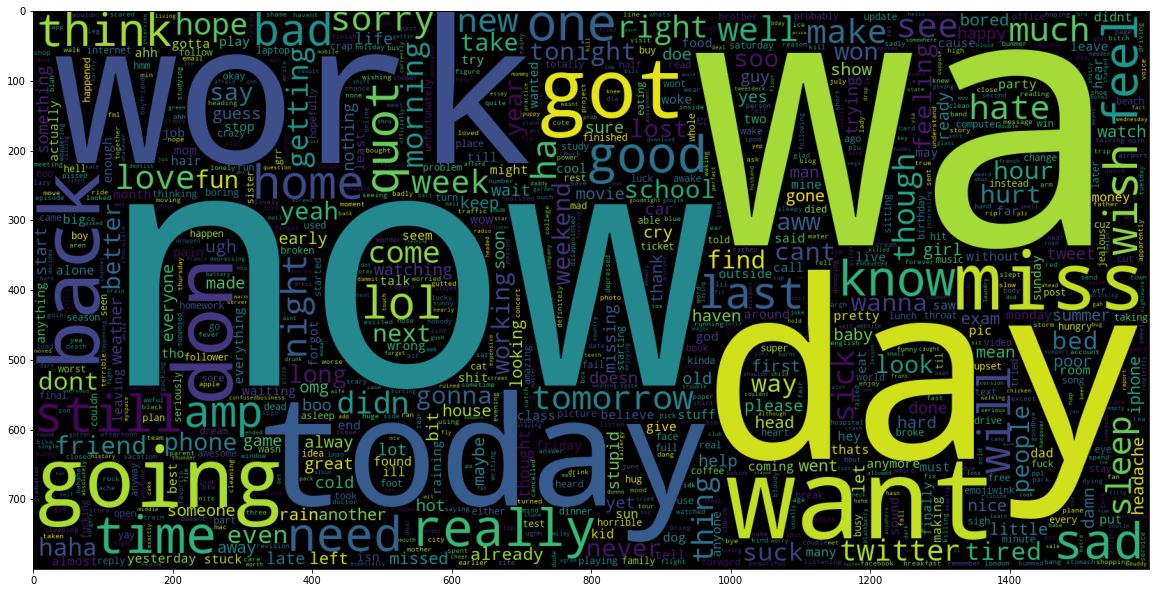

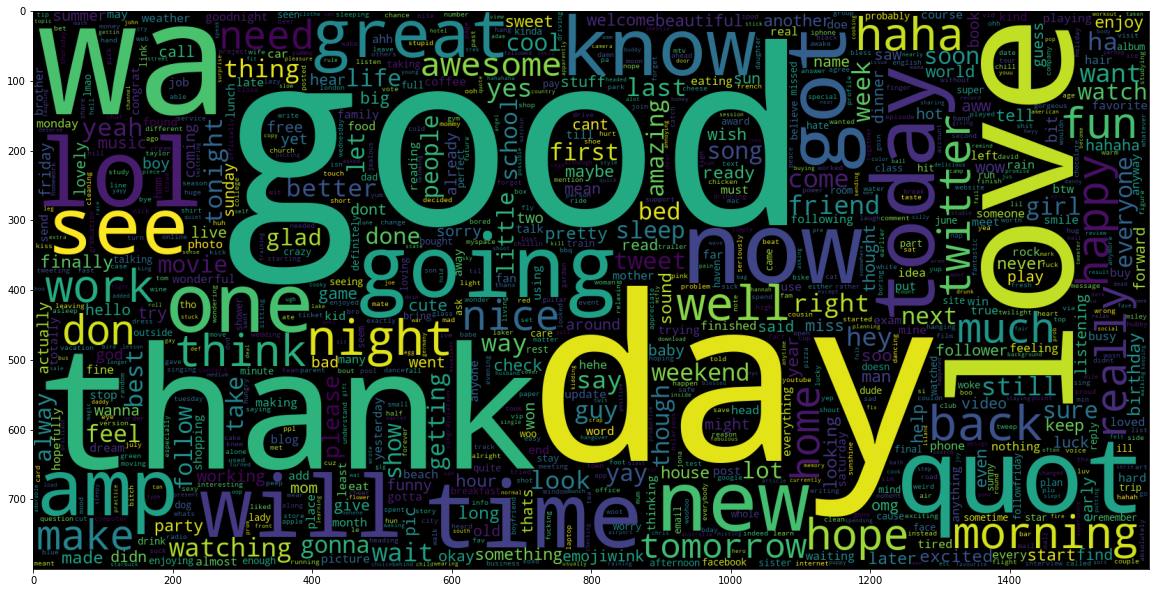

In [10]:
# CREATING WORDCLOUDS : creating two wordclouds one for negative sentiments and
#                       other for positive sentiments to find the words most 
#                       used in negative and positive tweets respectively.

negative_sentiments = preprocessedtext[:800000]
data_neg = []
for words in negative_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_neg.append(words)
    

word_cloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False)
plt.figure(figsize = (20,20))
negative_wc = word_cloud.generate(" ".join(data_neg))
plt.imshow(negative_wc)


positive_sentiments = preprocessedtext[800000:]
data_pos = []
for words in positive_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_pos.append(words)

plt.figure(figsize = (20,20))
positive_wc = word_cloud.generate(" ".join(data_pos))
plt.imshow(positive_wc)

In [11]:
# SPLIT THE DATA : splitting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(preprocessedtext, sentiment,test_size = 0.05, random_state = 0)

In [12]:
# TF - IDF VECTORIZER : vectorizing the data to pass to models.

vectoriser = TfidfVectorizer(ngram_range=(1,2),stop_words = stopwordlist, strip_accents = 'unicode', max_features = 500000)
vectoriser.fit(X_train) 
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [13]:
# FUNCTION TO EVALUATE , PREDICT

def model_Evaluate(model):
    
    y_pred = model.predict(X_test) 
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)] #converting confusion matrix value to percentage in 2 decimal places.

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

def predict(vectoriser, model, text):
    textdata = vectoriser.transform(preprocess(text)) 
    sentiment = model.predict(textdata)
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], categories) 
    return df

Time Taken : 0.676673173904419
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39989
           1       0.78      0.80      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



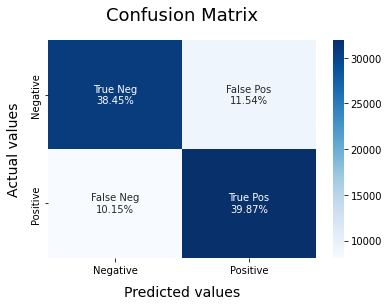

In [ ]:
# Bernoulli Naive Bayes Model

BNB = BernoulliNB(alpha = 2)
start = time.time()
BNB.fit(X_train, y_train)
print("Time Taken : " + str(time.time() - start))
model_Evaluate(BNB)
file = open('BNB Model.pickle','wb')
pickle.dump(BNB, file)
file.close()

Time Taken : 27.158339500427246
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39989
           1       0.77      0.80      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



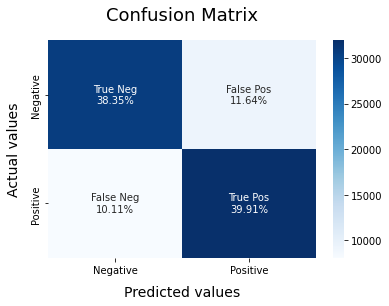

In [ ]:
# Support Vector Machine Model

SVC = LinearSVC()
start = time.time()
SVC.fit(X_train, y_train)
print("Time Taken : "+ str(time.time() - start))
model_Evaluate(SVC)
file = open('SVC Model.pickle','wb')
pickle.dump(SVC, file)
file.close()

Time Taken : 246.46008896827698
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



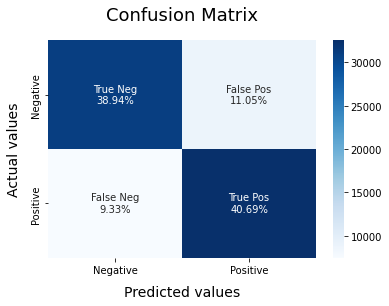

In [ ]:
# Logistic Regression Model

LR = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
start = time.time()
LR.fit(X_train, y_train)
print("Time Taken : "+ str(time.time() - start))
model_Evaluate(LR)
file = open("Logistic Regression Model.pickle",'wb')
pickle.dump(LR,file)
file.close()

Time Taken : 160.922621011734
              precision    recall  f1-score   support

           0       0.75      0.72      0.74     39989
           1       0.73      0.76      0.75     40011

    accuracy                           0.74     80000
   macro avg       0.74      0.74      0.74     80000
weighted avg       0.74      0.74      0.74     80000



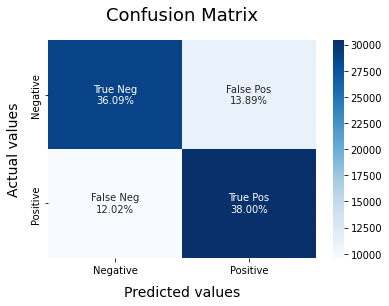

In [ ]:
# Light Gradient Boosted Machine Model

LGBM = LGBMClassifier()
start = time.time()
LGBM.fit(X_train, y_train)
print("Time Taken : "+str(time.time() - start))
model_Evaluate(LGBM)
file = open("LGBM Model.pickle",'wb')
pickle.dump(LGBM,file)
file.close()

Time Taken : 0.8968031406402588
              precision    recall  f1-score   support

           0       0.79      0.78      0.78     39989
           1       0.78      0.79      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



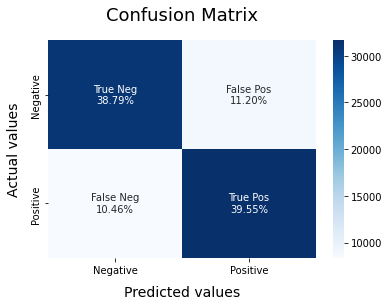

In [14]:
# Multinomial Naive Bayes Model

NB = MultinomialNB()
start = time.time()
NB.fit(X_train, y_train)
print("Time Taken : " + str(time.time() - start))
model_Evaluate(NB)
file = open("Multinomial NB.pickle",'wb')
pickle.dump(NB,file)
file.close()